In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

# Add line profiler
%load_ext line_profiler

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import subprocess
import os
import gc
import datetime
import importlib

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Set large figure sizes
#Note, this prevents nice figures for articles...
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
#from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
class CudaContext(object):
    def __init__(self, verbose=True, blocking=False):
        self.verbose = verbose
        self.blocking = blocking
        
        cuda.init(flags=0)
        
        try:
            cuda.Context.pop()
            if (self.verbose):
                print("=== WARNING ===")
                print("Popped existing context")
                print("=== WARNING ===")
        except:
            pass
        
        if (self.verbose):
            print("CUDA version " + str(cuda.get_version()))
            print("Driver version " + str(cuda.get_driver_version()))

        self.cuda_device = cuda.Device(0)
        if (self.verbose):
            print("Using " + self.cuda_device.name())
            print(" => compute capability: " + str(self.cuda_device.compute_capability()))
            print(" => memory: " + str(self.cuda_device.total_memory() / (1024*1024)) + " MB")

        if (self.blocking):
            self.cuda_context = self.cuda_device.make_context(flags=cuda.ctx_flags.SCHED_BLOCKING_SYNC)
            if (self.verbose):
                print("=== WARNING ===")
                print("Using blocking context")
                print("=== WARNING ===")
        else:
            self.cuda_context = self.cuda_device.make_context(flags=cuda.ctx_flags.SCHED_AUTO)
            
    
    def __del__(self, *args):
        if self.verbose:
            print("Cleaning up CUDA context")
            
        self.cuda_context.detach()
        cuda.Context.pop()

            
my_context = CudaContext(verbose=True, blocking=False)

CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB


In [3]:
import time
class Timer(object):
    def __init__(self, tag, verbose=True):
        self.verbose = verbose
        self.tag = tag
        
    def __enter__(self):
        self.start = time.time()
        return self
    
    def __exit__(self, *args):
        self.end = time.time()
        self.secs = self.end - self.start
        self.msecs = self.secs * 1000 # millisecs
        if self.verbose:
            print("=> " + self.tag + ' %f ms' % self.msecs)
            
with Timer("sleep", verbose=True) as t:
    time.sleep(0.125)
    
print("=> elapsed time: %f s" % t.secs)

=> sleep 125.088930 ms
=> elapsed time: 0.125089 s


In [4]:
def gen_test_data(nx, ny, num_ghost_cells):
    width = 100.0
    height = width
    dx = width / float(nx)
    dy = height / float(ny)

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    size = width 
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        y = dy*(j+0.5) - y_center
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size + y**2/size))
            #hu[j+num_ghost_cells, i+num_ghost_cells] = 0.01*np.sin(x)*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size + y**2/size))
            hv[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size + y**2/size))
    
    return h, hu, hv, dx, dy, nx, ny

In [5]:
#%lprun -f gen_test_data gen_test_data(100, 150, 2)

In [6]:
from SWESimulators import Common
importlib.reload(Common)

nx = 1000
ny = 1500
nx_halo = 2
ny_halo = 3
a = np.random.rand(ny+2*ny_halo, nx+2*nx_halo).astype(np.float32)

import pycuda.driver as cuda
stream = cuda.Stream()

with Timer("upload (async)", verbose=True) as t:
    a_gpu = Common.CUDAArray2D(stream, nx, ny, nx_halo, ny_halo, a)

with Timer("download (async)", verbose=True) as t:
    b = a_gpu.download(stream, async=True)
    
with Timer("sync", verbose=True) as t:
    cuda.Context.synchronize()
    
print("Sum of absolute difference: ", np.sum(np.abs(a-b)))

=> upload (async) 8.011341 ms
=> download (async) 20.012617 ms
=> sync 0.000000 ms
Sum of absolute difference:  0.0


In [7]:
with Timer("compile", verbose=True) as t:
    module = Common.get_kernel("FORCE_kernel.cu", 16, 16)

=> compile 6411.859989 ms


In [8]:
#%lprun -f Common.get_kernel Common.get_kernel("FORCE_kernel.cu", 16, 16)

=> construct 4934.113741 ms
=> step 14.986992 ms
=> download 2.002239 ms


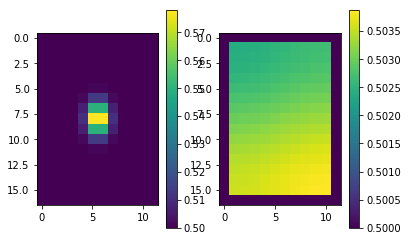

In [9]:
from SWESimulators import LxF
importlib.reload(LxF)

nx = 10
ny = 15
num_ghost_cells = 1
dt = 0.1
g = 9.81

h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ny, num_ghost_cells)
plt.figure()
plt.subplot(121)
plt.imshow(h0)
plt.colorbar()

with Timer("construct") as t:
    sim = LxF.LxF(h0, hu0, hv0, \
                    nx, ny, \
                    dx, dy, dt, \
                    g)

with Timer("step") as t:
    t = sim.step(10.0)
    
with Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.subplot(122)
plt.imshow(h1)
plt.colorbar()

=> construct 4916.617155 ms
=> step 118.532658 ms
=> download 0.992298 ms


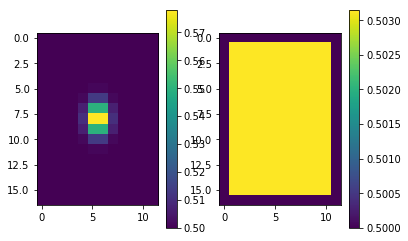

In [10]:
from SWESimulators import FORCE
importlib.reload(FORCE)

nx = 10
ny = 15
num_ghost_cells = 1
dt = 0.01
g = 9.81

h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ny, num_ghost_cells)
plt.figure()
plt.subplot(121)
plt.imshow(h0)
plt.colorbar()

with Timer("construct") as t:
    sim = FORCE.FORCE(h0, hu0, hv0, \
                    nx, ny, \
                    dx, dy, dt, \
                    g)

with Timer("step") as t:
    t = sim.step(10.0)
    
with Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.subplot(122)
plt.imshow(h1)
plt.colorbar()

=> construct 4879.117727 ms
=> step 109.936714 ms
=> download 2.000093 ms


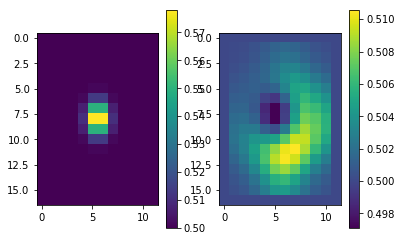

In [11]:
from SWESimulators import HLL
importlib.reload(HLL)

nx = 10
ny = 15
num_ghost_cells = 1
dt = 0.01
g = 9.81

h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ny, num_ghost_cells)
plt.figure()
plt.subplot(121)
plt.imshow(h0)
plt.colorbar()

with Timer("construct") as t:
    sim = HLL.HLL(h0, hu0, hv0, \
                    nx, ny, \
                    dx, dy, dt, \
                    g)

with Timer("step") as t:
    t = sim.step(10.0)
    
with Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.subplot(122)
plt.imshow(h1)
plt.colorbar()